# The Economics of Film
#### By Ariana Rozsnyoi, Caitlin Apcar, Mikhail Pavlov and Zachary Ash

## Import statements

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Creating a usable Dataframe

With our data coming from two seperate sources, it was ideal to merge them into a single data set as they both contained the same films but had varying columns.

In [151]:
#First Dataset from ....

movie_data = pd.read_csv("data/movie_metadata.csv")

Exploring and cleaning the data

In [152]:
movie_data.shape

(5043, 28)

In [153]:
movie_data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [154]:
#Dropping any duplicate films
#movie_data.drop_duplicates(keep=False, inplace=True)

In [155]:
movie_data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [156]:
#Second Dataset from ...
movies = pd.read_csv("data/movies.csv")

In [157]:
movies.shape

(212385, 14)

In [158]:
movies.head()

,id,budget,genres,imdb_id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,title,vote_average,vote_count
0,5,4000000,Crime|Comedy,tt0113101,en,Four Rooms,1.698,Miramax Films,United States of America,25-12-95,4300000,Four Rooms,6.5,485
1,6,0,Action|Thriller|Crime,tt0107286,en,Judgment Night,1.32287,Universal Pictures,Japan,15-10-93,12136938,Judgment Night,6.5,69
2,8,42000,Documentary,tt0825671,en,Life in Loops (A Megacities RMX),0.054716,inLoops,Austria,01-01-06,0,Life in Loops (A Megacities RMX),6.4,4
3,11,11000000,Adventure|Action|Science Fiction,tt0076759,en,Star Wars,10.492614,Lucasfilm,United States of America,25-05-77,775398007,Star Wars,8.0,6168
4,12,94000000,Animation|Family,tt0266543,en,Finding Nemo,9.915573,Pixar Animation Studios,United States of America,30-05-03,940335536,Finding Nemo,7.6,5531


In [159]:
movies.columns.tolist 

<bound method IndexOpsMixin.tolist of Index(['id', 'budget', 'genres', 'imdb_id', 'original_language',
       'original_title', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'title',
       'vote_average', 'vote_count'],
      dtype='object')>

To easily join the data frames we first need to extract the imdb id from the movie link url in the first data frame.

In [160]:
print(movie_data['movie_imdb_link'][2])
test = movie_data['movie_imdb_link'][2].split('/')
test[-2]

http://www.imdb.com/title/tt2379713/?ref_=fn_tt_tt_1


'tt2379713'

In [161]:
len(movie_data['movie_imdb_link'])

5043

In [162]:
#get length of the col
total_len = len(movie_data['movie_imdb_link'])
values = []
for i in range(total_len):
    value = movie_data['movie_imdb_link'][i].split('/')[-2]
    values.append(value)#split the string to obtain id
movie_data['imdb_id'] = values #add the values in a new column

In [163]:
#check that id matches
movie_data[['imdb_id','movie_imdb_link']].head(10)

,imdb_id,movie_imdb_link
0,tt0499549,http://www.imdb.com/title/tt0499549/?ref_=fn_t...
1,tt0449088,http://www.imdb.com/title/tt0449088/?ref_=fn_t...
2,tt2379713,http://www.imdb.com/title/tt2379713/?ref_=fn_t...
3,tt1345836,http://www.imdb.com/title/tt1345836/?ref_=fn_t...
4,tt5289954,http://www.imdb.com/title/tt5289954/?ref_=fn_t...
5,tt0401729,http://www.imdb.com/title/tt0401729/?ref_=fn_t...
6,tt0413300,http://www.imdb.com/title/tt0413300/?ref_=fn_t...
7,tt0398286,http://www.imdb.com/title/tt0398286/?ref_=fn_t...
8,tt2395427,http://www.imdb.com/title/tt2395427/?ref_=fn_t...
9,tt0417741,http://www.imdb.com/title/tt0417741/?ref_=fn_t...


In [164]:
#example
for index, row in movie_data.iterrows():
    if row['imdb_id'] == 'tt0499549':
        print(row['movie_title'])

Avatar 


Now that we have the imbd id in both datasets, we can combine them into a single dataframe.

In [165]:
new_df = pd.merge(movies,movie_data,on='imdb_id')

In [166]:
new_df.shape

(4594, 42)

In [167]:
new_df.columns

Index(['id', 'budget_x', 'genres_x', 'imdb_id', 'original_language',
       'original_title', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'title',
       'vote_average', 'vote_count', 'color', 'director_name',
       'num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes',
       'gross', 'genres_y', 'actor_1_name', 'movie_title', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
       'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language',
       'country', 'content_rating', 'budget_y', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes'],
      dtype='object')

In [168]:
new_df.head()

,id,budget_x,genres_x,imdb_id,original_language,original_title,popularity,production_companies,production_countries,release_date,...,num_user_for_reviews,language,country,content_rating,budget_y,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,5,4000000,Crime|Comedy,tt0113101,en,Four Rooms,1.698,Miramax Films,United States of America,25-12-95,...,177.0,English,USA,R,4000000.0,1995.0,975.0,6.7,1.85,0
1,11,11000000,Adventure|Action|Science Fiction,tt0076759,en,Star Wars,10.492614,Lucasfilm,United States of America,25-05-77,...,1470.0,English,USA,PG,11000000.0,1977.0,1000.0,8.7,2.35,33000
2,12,94000000,Animation|Family,tt0266543,en,Finding Nemo,9.915573,Pixar Animation Studios,United States of America,30-05-03,...,866.0,English,USA,G,94000000.0,2003.0,939.0,8.2,1.85,11000
3,13,55000000,Comedy|Drama|Romance,tt0109830,en,Forrest Gump,10.351236,Paramount Pictures,United States of America,06-07-94,...,1398.0,English,USA,PG-13,55000000.0,1994.0,294.0,8.8,2.35,59000
4,14,15000000,Drama,tt0169547,en,American Beauty,8.191009,DreamWorks SKG,United States of America,15-09-99,...,2715.0,English,USA,R,15000000.0,1999.0,828.0,8.4,2.35,22000


# Dropping Irrelevant Columns

There are a number of columns in our merged dataframe that will not provide anything of use in our analysis so they will be dropped.

In [169]:
new_df= new_df.drop(['id', 'title','original_language', 'popularity', 'vote_count', 'color', 'num_critic_for_reviews', 'duration'
                             , 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'plot_keywords', 
                             'movie_imdb_link', 'num_user_for_reviews', 'content_rating', 'aspect_ratio', 'original_title' ], axis=1) 

In [170]:
new_df.columns

Index(['budget_x', 'genres_x', 'imdb_id', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'vote_average',
       'director_name', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_2_name', 'actor_1_facebook_likes', 'gross', 'genres_y',
       'actor_1_name', 'movie_title', 'actor_3_name', 'language', 'country',
       'budget_y', 'title_year', 'actor_2_facebook_likes', 'imdb_score',
       'movie_facebook_likes'],
      dtype='object')

In [171]:
new_df.shape

(4594, 25)

In [172]:
new_df.head()

,budget_x,genres_x,imdb_id,production_companies,production_countries,release_date,revenue,vote_average,director_name,director_facebook_likes,...,actor_1_name,movie_title,actor_3_name,language,country,budget_y,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
0,4000000,Crime|Comedy,tt0113101,Miramax Films,United States of America,25-12-95,4300000,6.5,Allison Anders,99.0,...,Salma Hayek,Four Rooms,Lili Taylor,English,USA,4000000.0,1995.0,975.0,6.7,0
1,11000000,Adventure|Action|Science Fiction,tt0076759,Lucasfilm,United States of America,25-05-77,775398007,8.0,George Lucas,0.0,...,Harrison Ford,Star Wars: Episode IV - A New Hope,Kenny Baker,English,USA,11000000.0,1977.0,1000.0,8.7,33000
2,94000000,Animation|Family,tt0266543,Pixar Animation Studios,United States of America,30-05-03,940335536,7.6,Andrew Stanton,475.0,...,Alexander Gould,Finding Nemo,Brad Garrett,English,USA,94000000.0,2003.0,939.0,8.2,11000
3,55000000,Comedy|Drama|Romance,tt0109830,Paramount Pictures,United States of America,06-07-94,677945399,8.2,Robert Zemeckis,0.0,...,Tom Hanks,Forrest Gump,Sam Anderson,English,USA,55000000.0,1994.0,294.0,8.8,59000
4,15000000,Drama,tt0169547,DreamWorks SKG,United States of America,15-09-99,356296601,7.9,Sam Mendes,0.0,...,Kevin Spacey,American Beauty,Ara Celi,English,USA,15000000.0,1999.0,828.0,8.4,22000


In [175]:
#Reordering columns for easy reading
sequence = ['imdb_id', 'movie_title','title_year','budget_x', 'genres_x',  'production_companies',
       'production_countries', 'release_date', 'revenue', 
       'vote_average', 'director_name', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes',
       'gross', 'genres_y', 'actor_1_name',  'actor_3_name',
       'language', 'country', 'budget_y', 
       'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes']
new_df = new_df.reindex(columns=sequence)

In [176]:
new_df.head()

,imdb_id,movie_title,title_year,budget_x,genres_x,production_companies,production_countries,release_date,revenue,vote_average,...,gross,genres_y,actor_1_name,actor_3_name,language,country,budget_y,actor_2_facebook_likes,imdb_score,movie_facebook_likes
0,tt0113101,Four Rooms,1995.0,4000000,Crime|Comedy,Miramax Films,United States of America,25-12-95,4300000,6.5,...,4301331.0,Comedy|Fantasy,Salma Hayek,Lili Taylor,English,USA,4000000.0,975.0,6.7,0
1,tt0076759,Star Wars: Episode IV - A New Hope,1977.0,11000000,Adventure|Action|Science Fiction,Lucasfilm,United States of America,25-05-77,775398007,8.0,...,460935665.0,Action|Adventure|Fantasy|Sci-Fi,Harrison Ford,Kenny Baker,English,USA,11000000.0,1000.0,8.7,33000
2,tt0266543,Finding Nemo,2003.0,94000000,Animation|Family,Pixar Animation Studios,United States of America,30-05-03,940335536,7.6,...,380838870.0,Adventure|Animation|Comedy|Family,Alexander Gould,Brad Garrett,English,USA,94000000.0,939.0,8.2,11000
3,tt0109830,Forrest Gump,1994.0,55000000,Comedy|Drama|Romance,Paramount Pictures,United States of America,06-07-94,677945399,8.2,...,329691196.0,Comedy|Drama,Tom Hanks,Sam Anderson,English,USA,55000000.0,294.0,8.8,59000
4,tt0169547,American Beauty,1999.0,15000000,Drama,DreamWorks SKG,United States of America,15-09-99,356296601,7.9,...,130058047.0,Drama,Kevin Spacey,Ara Celi,English,USA,15000000.0,828.0,8.4,22000


In [177]:
#Dropping any rows that had missing/NaN data in order for us to be able to change the data types
clean_df = new_df.dropna()

clean_df.shape

(3683, 25)

In [178]:
#Converting columns that had floating point data types to integers
clean_df.astype({'title_year': 'int32', 'budget_y': 'int32', 'gross': 'int32','director_facebook_likes': 'int32', 'actor_3_facebook_likes' : 'int32', 'actor_1_facebook_likes' : 'int32'}).dtypes

imdb_id                     object
movie_title                 object
title_year                   int32
budget_x                     int64
genres_x                    object
production_companies        object
production_countries        object
release_date                object
revenue                      int64
vote_average               float64
director_name               object
director_facebook_likes      int32
actor_3_facebook_likes       int32
actor_2_name                object
actor_1_facebook_likes       int32
gross                        int32
genres_y                    object
actor_1_name                object
actor_3_name                object
language                    object
country                     object
budget_y                     int32
actor_2_facebook_likes     float64
imdb_score                 float64
movie_facebook_likes         int64
dtype: object

# Splitting Genres

In our original dataframe, genres had been grouped together into a single column (`genres_x`). Obviously, films are classified into many genres and to have each genre apply to a seperate row would make for a messy (and enormous) dataframe. <br>

We created a dummy dataframe with each genre, which is then joined back into `clean_df` - each genre has it's own column and if it applies to a film it is marked with a `1` in that row.

In [179]:
#Creating a dummy dataframe for genres and joining it back into our original dataframe
clean_df = clean_df.join(clean_df.pop('genres_x').str.get_dummies('|'))

In [180]:
clean_df

,imdb_id,movie_title,title_year,budget_x,production_companies,production_countries,release_date,revenue,vote_average,director_name,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,tt0113101,Four Rooms,1995.0,4000000,Miramax Films,United States of America,25-12-95,4300000,6.5,Allison Anders,...,0,0,0,0,0,0,0,0,0,0
1,tt0076759,Star Wars: Episode IV - A New Hope,1977.0,11000000,Lucasfilm,United States of America,25-05-77,775398007,8.0,George Lucas,...,0,0,0,0,0,0,1,0,0,0
2,tt0266543,Finding Nemo,2003.0,94000000,Pixar Animation Studios,United States of America,30-05-03,940335536,7.6,Andrew Stanton,...,0,0,0,0,0,0,0,0,0,0
3,tt0109830,Forrest Gump,1994.0,55000000,Paramount Pictures,United States of America,06-07-94,677945399,8.2,Robert Zemeckis,...,0,0,0,0,0,1,0,0,0,0
4,tt0169547,American Beauty,1999.0,15000000,DreamWorks SKG,United States of America,15-09-99,356296601,7.9,Sam Mendes,...,0,0,0,0,0,0,0,0,0,0
5,tt0168629,Dancer in the Dark,2000.0,12800000,Fine Line Features,Argentina,17-05-00,40031879,7.6,Lars von Trier,...,0,0,0,1,0,0,0,0,0,0
6,tt0119116,The Fifth Element,1997.0,90000000,Columbia Pictures,France,07-05-97,263920180,7.2,Luc Besson,...,0,0,0,0,0,0,1,1,0,0
7,tt0314412,My Life Without Me,2003.0,0,El Deseo,Canada,07-03-03,9726954,7.2,Isabel Coixet,...,0,0,0,0,0,1,0,0,0,0
8,tt0325980,Pirates of the Caribbean: The Curse of the Bla...,2003.0,140000000,Walt Disney Pictures,United States of America,09-07-03,655011224,7.4,Gore Verbinski,...,0,0,0,0,0,0,0,0,0,0
9,tt0266697,Kill Bill: Vol. 1,2003.0,30000000,Miramax Films,United States of America,10-10-03,180949000,7.7,Quentin Tarantino,...,0,0,0,0,0,0,0,0,0,0


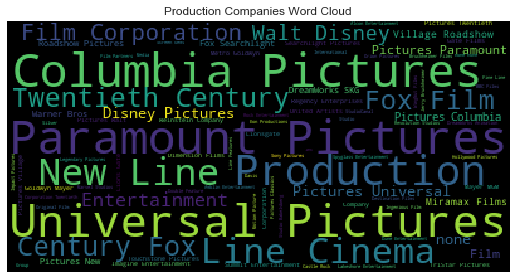

In [181]:
# Create a wordcloud to display most common Production Companies
from wordcloud import WordCloud
y = WordCloud().generate(' '.join(clean_df['production_companies']))
plt.rcParams["figure.figsize"] = (9,9)
plt.title('Production Companies Word Cloud')
plt.imshow(y)
plt.axis("off")
plt.show()